In [2]:
using Pkg
Pkg.activate("../Project.toml")

using ITensors
using Plots
using Random
using Interpolations
using LegendrePolynomials
using Distributions
# using ClassicalOrthogonalPolynomials
using Integrals
using KernelDensity
include("RealRealHighDimension.jl")


  Activating project at `~/Documents/QML Project/QuantumInspiredML`


fitMPS

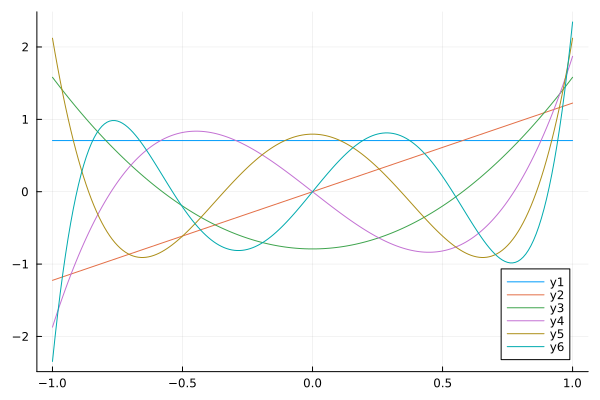

In [6]:
xs = collect(-1:0.01:1)

ys = (Pl.(xs, 0; norm = Val(:normalized)))
p = plot(xs, ys)
for i in 1:5
    ys =(Pl.(xs, i; norm = Val(:normalized)))
    plot!(p,xs, ys)
end
p

In [7]:
all([Pl(1,i; norm=Val(:normalized)) for i in 1:1000] .>= 0 )

true

In [8]:
encoding = legendre()

(X_train, y_train), (X_val, y_val), (X_test, y_test) = load_splits_txt("datasets/ECG_train.txt", 
"datasets/ECG_val.txt", "datasets/ECG_test.txt");
X_train = vcat(X_train, X_val);
y_train = vcat(y_train, y_val);

scaler = fit_scaler(RobustSigmoidTransform, X_train);
erange = encoding.range
X_train_scaled = transform_data(scaler, X_train; range=erange)
X_train_scaled2 = transform_data(scaler, X_train; minmax_output=false, range=erange)

X_val_scaled = transform_data(scaler, X_val; range=erange)
X_test_scaled = transform_data(scaler, X_test; range=erange);

In [9]:
@show size(X_train_scaled), length(y_train)

(size(X_train_scaled), length(y_train)) = ((100, 96), 100)


((100, 96), 100)

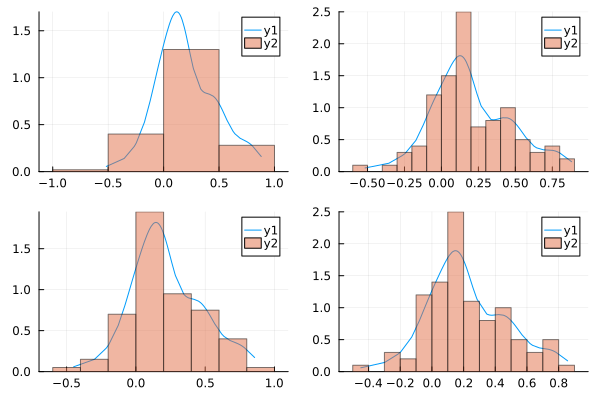

In [10]:
xs1 = sort(X_train_scaled[:,1])
xs2 = sort(X_train_scaled2[:,1])

kdense1_1 = kde(xs1;)
kdense1_2 = kde(xs1; bandwidth=0.08)


kdense2_1 = kde(xs2;)
kdense2_2 = kde(xs2; bandwidth=0.08)


ys1_1 = pdf(kdense1_1, xs1)
ys1_2 = pdf(kdense1_2, xs1)

ys2_1 = pdf(kdense2_1, xs2)
ys2_2 = pdf(kdense2_2, xs2)

p1_1 = plot(xs1, ys1_1)
histogram!(p1_1, xs1, alpha=0.5, norm=:pdf, bins=6)

p1_2= plot(xs1, ys1_2)
histogram!(p1_2, xs1, alpha=0.5, norm=:pdf, bins=15)



p2_1 = plot(xs2, ys2_1)
histogram!(p2_1, xs2, alpha=0.5, norm=:pdf, bins=6)

p2_2= plot(xs2, ys2_2)
histogram!(p2_2, xs2, alpha=0.5, norm=:pdf, bins=15)

plot(p1_1,p1_2, p2_1, p2_2; layout=(2,2))

(100, 96)

In [84]:
size(mean(X_train_scaled; dims=1))

(1, 96)

In [28]:
xsd = sort(mean(X_train_scaled; dims=1)[:])
kdense = kde(xsd; bandwidth=0.08)
xs = range(-1,1,200)
ys = pdf(kdense, xs)

wf = sqrt.(ys);

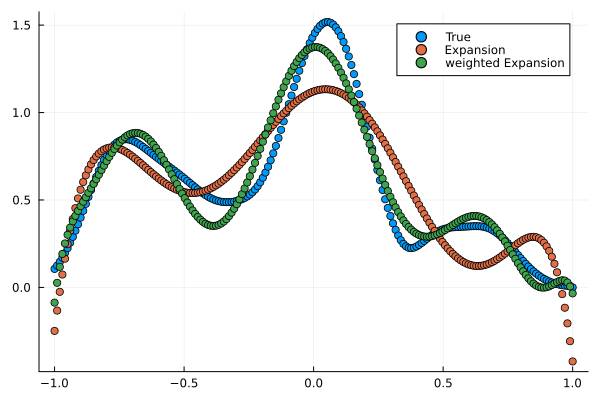

In [38]:
d = 8
nterms = 10*d

legfuncs = []
expansion = []
for i in 0:nterms-1
    ysi = Pl.(xs, i; norm = Val(:normalized))
    push!(legfuncs, ysi)
    problem = SampledIntegralProblem(wf .* ysi, xs)
    method = TrapezoidalRule()
    push!(expansion, solve(problem, method).u)
end

ysexp = zeros(length(ys))
ysappr = zeros(length(ys))

for i in 1:d

    ysexp .+= expansion[i] .* legfuncs[i]

end

inds = partialsortperm(abs2.(expansion), 1:d; rev=true)

for i in inds

    ysappr .+= expansion[i] .* legfuncs[i]

end


scatter(xs, wf; label="True")
#scatter!(xs, ysexp; label="Series")
scatter!(xs, ysexp; label="Expansion")
scatter!(xs, ysappr; label="weighted Expansion")


In [39]:
partialsortperm(abs2.(expansion), 1:d; rev=true)




8-element view(::Vector{Int64}, 1:8) with eltype Int64:
  1
  3
  7
  9
  2
  6
 11
  5

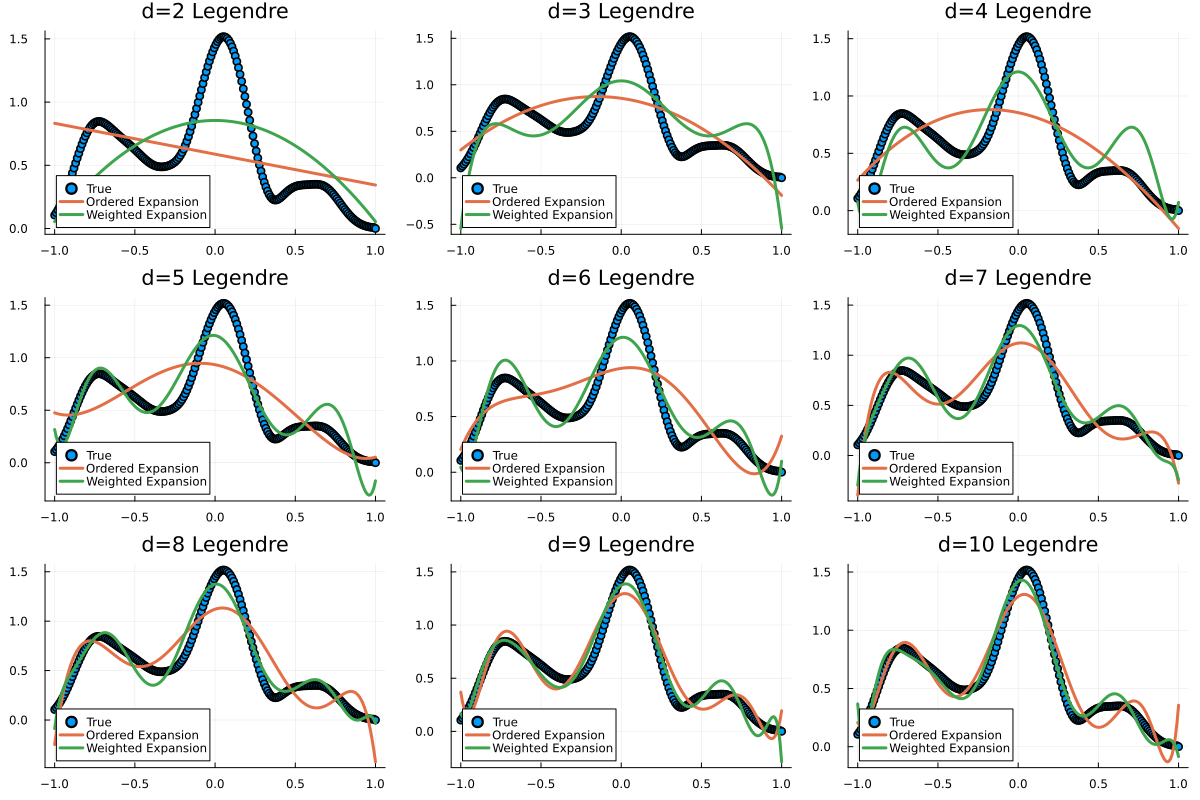

In [104]:
d = 8
nterms = 50#100*d

legfuncs = []
expansion = []
f = (x,l) -> Pl(x, l; norm=Val(:normalized))
for i in 0:nterms-1
    ysi = f.(xs, i)
    push!(legfuncs, ysi)
    problem = SampledIntegralProblem(wf .* ysi, xs)
    method = TrapezoidalRule()
    push!(expansion, solve(problem, method).u)
end

ysexp = zeros(length(ys))


# for (i,w) in enumerate(expansion)

#     ysexp .+= w .* legfuncs[i]

# end
ps = []
for d in 2:10
    ysappr = zeros(length(ys))
    inds = partialsortperm(abs2.(expansion), 1:d; rev=true)

    for i in inds

        ysappr .+= expansion[i] .* legfuncs[i]

    end

    ysexp = zeros(length(ys))

    for i in 1:d

        ysexp .+= expansion[i] .* legfuncs[i]

    end



    p = scatter(xs, wf; label="True", title="d=$d Legendre", legend=:bottomleft)
    plot!(p, xs, ysexp; label="Ordered Expansion", linewidth=3)
    plot!(p, xs, ysappr; label="Weighted Expansion", linewidth=3)
    push!(ps,p)
end

plot(ps..., size=(1200,800))


In [79]:
inds

10-element view(::Vector{Int64}, 1:10) with eltype Int64:
  1
  3
  7
  9
  2
  6
 11
  5
 12
 13

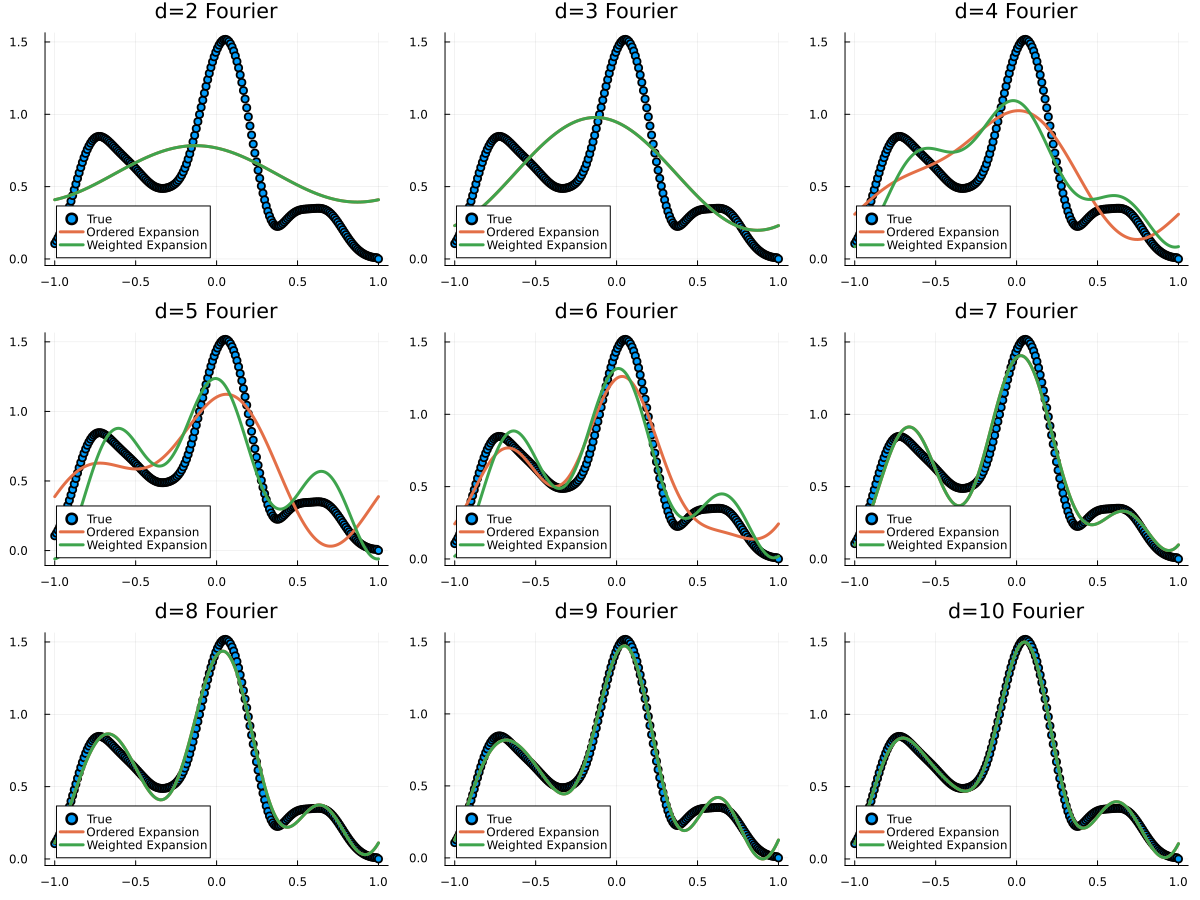

In [109]:
# Fourier

d = 8

nterms = 10*d
freqs = get_fourier_freqs(nterms)

legfuncs = []
expansion = []
f = (x,l) -> cispi.(x * freqs[l+1])
for i in 0:nterms-1
    ysi = f.(xs, i)
    push!(legfuncs, ysi)
    problem = SampledIntegralProblem(wf .* conj.(ysi), xs)
    method = TrapezoidalRule()
    push!(expansion, 0.5*solve(problem, method).u)
end





ps = []
for d in 2:10
    ysappr = zeros(ComplexF64,length(ys))
    inds = partialsortperm(abs2.(expansion), 1:d; rev=true)

    for i in inds

        ysappr .+= expansion[i] .* legfuncs[i]

    end

    ysexp = zeros(ComplexF64, length(ys))

    for i in 1:d
        
        ysexp .+= expansion[i] .* legfuncs[i]

    end



    p = scatter(xs, wf; label="True", title="d=$d Fourier", legend=:bottomleft)
    plot!(p, xs, real.(ysexp); label="Ordered Expansion", linewidth=3)
    plot!(p, xs, real.(ysappr); label="Weighted Expansion", linewidth=3)
    push!(ps,p)
end

plot(ps..., size=(1200,900))


In [74]:
inds

10-element view(::Vector{Int64}, 1:10) with eltype Int64:
  1
  2
  3
  6
  7
  4
  5
  8
  9
 10

In [62]:
freqs

-24:25

get_fourier_freqs (generic function with 1 method)

6-element Vector{Int64}:
  0
  1
 -1
  2
 -2
  3